# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Sun Dec 13 20:52:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P8    12W / 151W |    262MiB /  8192MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
!dir "D:/Datasets/thesis_dr/aptos2019-blindness-detection/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019-blindness-detection

12/13/2020  01:48 AM    <DIR>          .
12/13/2020  01:48 AM    <DIR>          ..
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
12/06/2020  07:46 AM         1,235,300 df_train_duplicate.csv
12/13/2020  01:46 AM    <DIR>          models
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/18/2019  03:23 AM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/18/2019  03:27 AM            54,948 train.csv
10/10/2020  08:35 AM    <DIR>          train_images
10/30/2020  07:20 PM    <DIR>          train_images_balance_mini
10/28/2020  11:42 PM    <DIR>          train_images_jpeg
12/11/2020  01:07 AM    <DIR>          train_images_rescaled_300
12/06/2020  07:20 AM    <DIR>          train_images_rescaled_300_btgraham
12/11/2020  01:07 AM    <DIR>          

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019-blindness-detection/'
dir_img = os.path.join(
    dir_base, 'train_images_rescaled_300_nakhon')

if os.path.isdir(os.path.join(dir_base, 'models/kfold_nakhon/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_nakhon/'))

In [6]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
lr_tune = 2e-6
epoch_init = 50
epoch_tune = 50
# decay_init = lr_init / epoch_init
# decay_tune = lr_tune / epoch_tune
save_csv = 'log_training-20201213.csv'
save_EOE_train_head = 'EOE_classifier-20201213.h5'
save_best_train_head = 'best_classifier-20201213.h5'
save_EOE_train_body = 'EOE_fine_tune-20201213.h5'
save_best_train_body = 'best_fine_tune-20201213.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [8]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3493,ffa47f6a7bf4.png,2
3494,ffc04fed30e6.png,0
3495,ffcf7b45f213.png,2
3496,ffd97f8cd5aa.png,0


In [10]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [13]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [17]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights='imagenet', input_shape=(image_shape))
    conv_base.trainable = False

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [18]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [19]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [20]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [21]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [22]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [23]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [24]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [25]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.png'

In [26]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.png,0


In [27]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

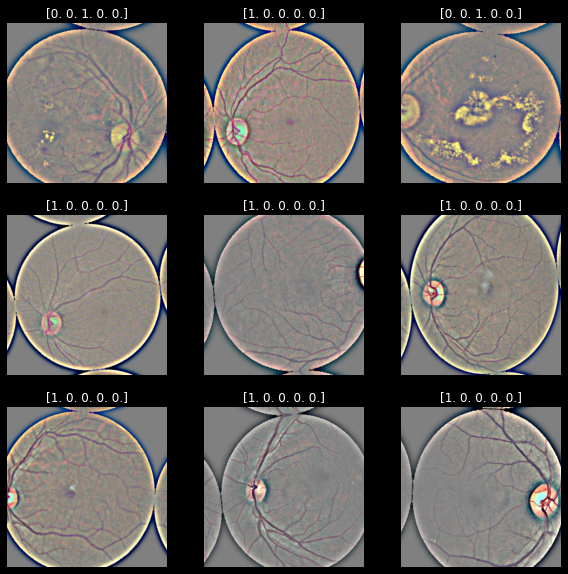

In [28]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [29]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [30]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [31]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.png'

In [32]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.png,0


In [33]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

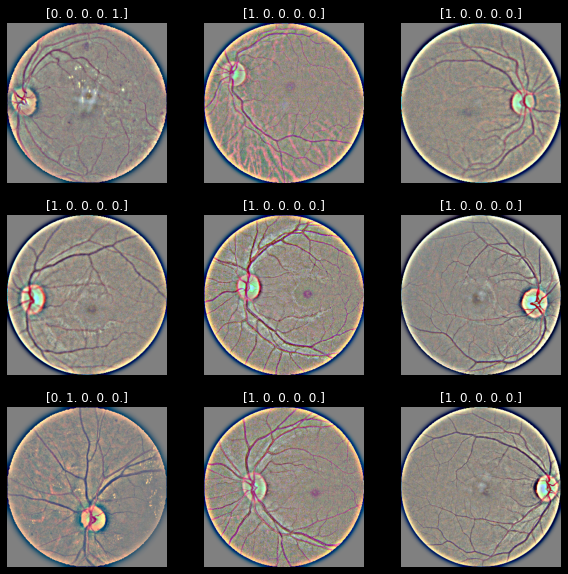

In [34]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [35]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [36]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.png,2
5,0083ee8054ee.png,4
9,00cb6555d108.png,1


In [37]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))

In [38]:
conv_base, model = create_model()

In [39]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [40]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [41]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 2s - loss: 10.6897 - categorical_accuracy: 0.4671 - precision: 0.5535 - recall: 0.3868 - auc: 0.7659
Epoch 00001: val_loss improved from inf to 10.04678, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_classifier-20201213.h5
88/88 [==============================] - 242s 3s/step - loss: 10.6834 - categorical_accuracy: 0.4682 - precision: 0.5541 - recall: 0.3881 - auc: 0.7665 - val_loss: 10.0468 - val_categorical_accuracy: 0.6729 - val_precision: 0.9025 - val_recall: 0.3571 - val_auc: 0.8958
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1925 - categorical_accuracy: 0.5430 - precision: 0.6155 - recall: 0.4584 - auc: 0.8202
Epoch 00002: val_loss improved from 10.04678 to 9.64966, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fo

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 4.1346 - categorical_accuracy: 0.6544 - precision: 0.7383 - recall: 0.5600 - auc: 0.9072
Epoch 00028: val_loss improved from 4.12086 to 3.97413, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_classifier-20201213.h5
88/88 [==============================] - 128s 1s/step - loss: 4.1330 - categorical_accuracy: 0.6544 - precision: 0.7381 - recall: 0.5600 - auc: 0.9073 - val_loss: 3.9741 - val_categorical_accuracy: 0.6614 - val_precision: 0.7926 - val_recall: 0.5843 - val_auc: 0.9291
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.9579 - categorical_accuracy: 0.6670 - precision: 0.7540 - recall: 0.5730 - auc: 0.9183
Epoch 00029: val_loss improved from 3.97413 to 3.85695, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_classifier-20201213.h5
88/88 [==============================] - 128s 1s/step - loss

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.7058 - categorical_accuracy: 0.6934 - precision: 0.7774 - recall: 0.6009 - auc: 0.9299
Epoch 00042: val_loss improved from 2.77498 to 2.73136, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss: 2.7067 - categorical_accuracy: 0.6923 - precision: 0.7766 - recall: 0.6001 - auc: 0.9298 - val_loss: 2.7314 - val_categorical_accuracy: 0.7157 - val_precision: 0.8139 - val_recall: 0.6371 - val_auc: 0.9444
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.6438 - categorical_accuracy: 0.7019 - precision: 0.7835 - recall: 0.5991 - auc: 0.9294
Epoch 00043: val_loss improved from 2.73136 to 2.64768, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss

In [42]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

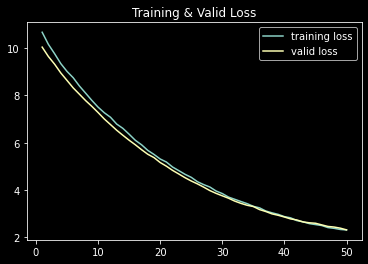

In [43]:
plot_loss(history)

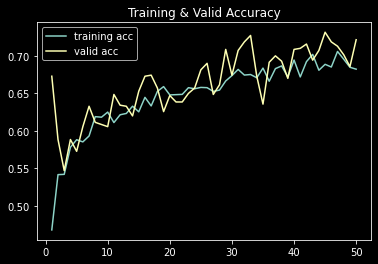

In [44]:
plot_acc(history)

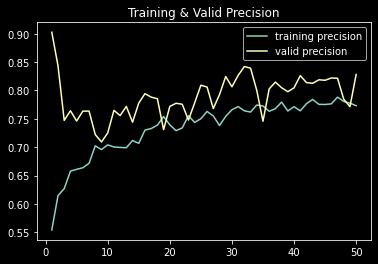

In [45]:
plot_precision(history)

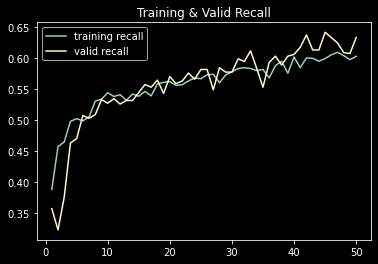

In [46]:
plot_recall(history)

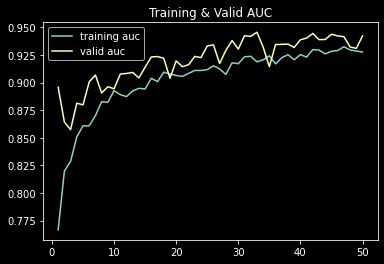

In [47]:
plot_auc(history)

### Evaluate model

In [48]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 12s 558ms/step - loss: 2.0135 - categorical_accuracy: 0.7214 - precision: 0.8280 - recall: 0.6329 - auc: 0.9422


[2.013513754714619, 0.7214286, 0.8280374, 0.63285714, 0.9422252]

In [49]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [50]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 503ms/step


In [51]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.98      0.95      0.96       359
         mild       0.43      0.63      0.51        67
     moderate       0.69      0.44      0.54       185
       severe       0.28      0.69      0.40        35
proliferative       0.34      0.31      0.33        54

     accuracy                           0.72       700
    macro avg       0.54      0.60      0.55       700
 weighted avg       0.76      0.72      0.73       700



In [52]:
confusion_matrix(y_true, y_pred)

array([[340,  14,   2,   2,   1],
       [  5,  42,  14,   2,   4],
       [  2,  34,  82,  44,  23],
       [  1,   1,   4,  24,   5],
       [  0,   6,  17,  14,  17]], dtype=int64)

## Fine Tune

In [53]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [55]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [56]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.2242 - categorical_accuracy: 0.7137 - precision: 0.7965 - recall: 0.6255 - auc: 0.9371
Epoch 00001: val_loss improved from inf to 2.30503, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_fine_tune-20201213.h5
88/88 [==============================] - 144s 2s/step - loss: 2.2241 - categorical_accuracy: 0.7127 - precision: 0.7953 - recall: 0.6247 - auc: 0.9370 - val_loss: 2.3050 - val_categorical_accuracy: 0.7200 - val_precision: 0.8305 - val_recall: 0.6371 - val_auc: 0.9428
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.2293 - categorical_accuracy: 0.7061 - precision: 0.7963 - recall: 0.6247 - auc: 0.9364
Epoch 00002: val_loss improved from 2.30503 to 2.30091, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\bes

88/88 [==============================] - 129s 1s/step - loss: 2.1532 - categorical_accuracy: 0.7262 - precision: 0.8094 - recall: 0.6526 - auc: 0.9424 - val_loss: 2.2733 - val_categorical_accuracy: 0.7200 - val_precision: 0.8133 - val_recall: 0.6471 - val_auc: 0.9435
Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.1365 - categorical_accuracy: 0.7372 - precision: 0.8145 - recall: 0.6479 - auc: 0.9437
Epoch 00015: val_loss improved from 2.27328 to 2.26804, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_fine_tune-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 2.1354 - categorical_accuracy: 0.7377 - precision: 0.8147 - recall: 0.6476 - auc: 0.9437 - val_loss: 2.2680 - val_categorical_accuracy: 0.7200 - val_precision: 0.8156 - val_recall: 0.6443 - val_auc: 0.9433
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.1391 - categorical_accuracy: 0.7307 - precision: 0.8042 - 

Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 2.1039 - categorical_accuracy: 0.7393 - precision: 0.8117 - recall: 0.6482 - auc: 0.9474
Epoch 00029: val_loss improved from 2.23670 to 2.23453, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_fine_tune-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 2.1044 - categorical_accuracy: 0.7391 - precision: 0.8108 - recall: 0.6480 - auc: 0.9473 - val_loss: 2.2345 - val_categorical_accuracy: 0.7300 - val_precision: 0.8303 - val_recall: 0.6500 - val_auc: 0.9465
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 2.0706 - categorical_accuracy: 0.7426 - precision: 0.8187 - recall: 0.6678 - auc: 0.9492
Epoch 00030: val_loss improved from 2.23453 to 2.22998, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_fine_tune-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 

Epoch 44/50
87/88 [============================>.] - ETA: 1s - loss: 2.0380 - categorical_accuracy: 0.7520 - precision: 0.8218 - recall: 0.6721 - auc: 0.9521
Epoch 00044: val_loss improved from 2.21070 to 2.20747, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold1\best_fine_tune-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 2.0350 - categorical_accuracy: 0.7523 - precision: 0.8220 - recall: 0.6719 - auc: 0.9523 - val_loss: 2.2075 - val_categorical_accuracy: 0.7314 - val_precision: 0.8157 - val_recall: 0.6514 - val_auc: 0.9473
Epoch 45/50
87/88 [============================>.] - ETA: 1s - loss: 2.0394 - categorical_accuracy: 0.7625 - precision: 0.8226 - recall: 0.6855 - auc: 0.9516
Epoch 00045: val_loss did not improve from 2.20747
88/88 [==============================] - 126s 1s/step - loss: 2.0386 - categorical_accuracy: 0.7623 - precision: 0.8220 - recall: 0.6848 - auc: 0.9511 - val_loss: 2.2122 - val_categorical_

In [57]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

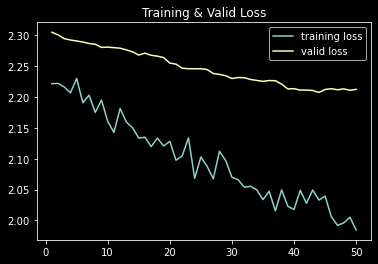

In [58]:
plot_loss(history)

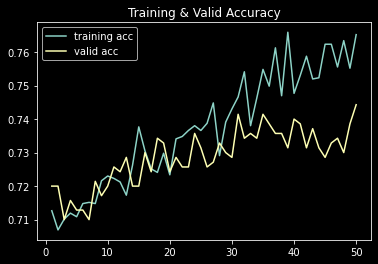

In [59]:
plot_acc(history)

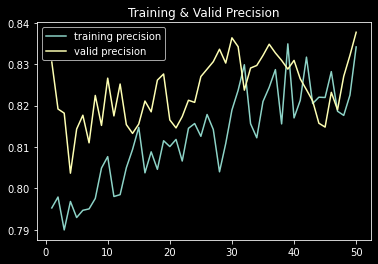

In [60]:
plot_precision(history)

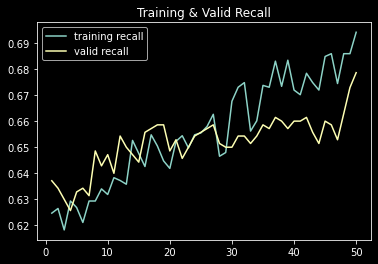

In [61]:
plot_recall(history)

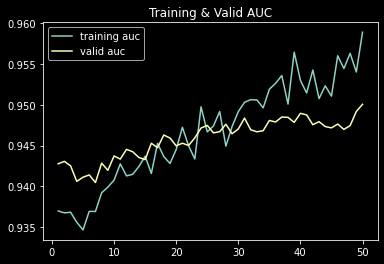

In [62]:
plot_auc(history)

### Evaluate model

In [63]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 570ms/step - loss: 1.8968 - categorical_accuracy: 0.7443 - precision: 0.8377 - recall: 0.6786 - auc: 0.9501


[1.8968467712402344, 0.7442857, 0.8377425, 0.6785714, 0.95005894]

In [64]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [65]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 546ms/step


In [66]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.98      0.96      0.97       359
         mild       0.44      0.72      0.55        67
     moderate       0.73      0.48      0.58       185
       severe       0.30      0.54      0.38        35
proliferative       0.39      0.39      0.39        54

     accuracy                           0.74       700
    macro avg       0.57      0.62      0.57       700
 weighted avg       0.78      0.74      0.75       700



In [67]:
confusion_matrix(y_true, y_pred)

array([[344,  12,   2,   1,   0],
       [  5,  48,  10,   2,   2],
       [  2,  41,  89,  31,  22],
       [  0,   2,   5,  19,   9],
       [  0,   6,  16,  11,  21]], dtype=int64)

# Fold 2

## Train classifier

In [68]:
del(model)

In [69]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [70]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.png,4
3,002c21358ce6.png,0
11,00e4ddff966a.png,2


In [71]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))

In [72]:
conv_base, model = create_model()

In [73]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [74]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [75]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7264 - categorical_accuracy: 0.4599 - precision: 0.5485 - recall: 0.3782 - auc: 0.7552
Epoch 00001: val_loss improved from inf to 10.02154, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\best_classifier-20201213.h5
88/88 [==============================] - 144s 2s/step - loss: 10.7192 - categorical_accuracy: 0.4600 - precision: 0.5473 - recall: 0.3781 - auc: 0.7551 - val_loss: 10.0215 - val_categorical_accuracy: 0.6629 - val_precision: 0.9321 - val_recall: 0.3729 - val_auc: 0.9025
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1107 - categorical_accuracy: 0.5484 - precision: 0.6328 - recall: 0.4635 - auc: 0.8280
Epoch 00002: val_loss improved from 10.02154 to 9.63250, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fo

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9303 - categorical_accuracy: 0.6768 - precision: 0.7570 - recall: 0.5734 - auc: 0.9190
Epoch 00028: val_loss improved from 4.08153 to 3.91122, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\best_classifier-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 3.9291 - categorical_accuracy: 0.6773 - precision: 0.7575 - recall: 0.5740 - auc: 0.9193 - val_loss: 3.9112 - val_categorical_accuracy: 0.6714 - val_precision: 0.7742 - val_recall: 0.5829 - val_auc: 0.9232
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8304 - categorical_accuracy: 0.6706 - precision: 0.7681 - recall: 0.5832 - auc: 0.9185
Epoch 00029: val_loss improved from 3.91122 to 3.78434, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\best_classifier-20201213.h5
88/88 [==============================] - 130s 1s/step - loss

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.5849 - categorical_accuracy: 0.6934 - precision: 0.7772 - recall: 0.6052 - auc: 0.9299
Epoch 00042: val_loss improved from 2.76543 to 2.69972, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss: 2.5883 - categorical_accuracy: 0.6923 - precision: 0.7769 - recall: 0.6047 - auc: 0.9295 - val_loss: 2.6997 - val_categorical_accuracy: 0.7114 - val_precision: 0.7934 - val_recall: 0.6143 - val_auc: 0.9331
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.5341 - categorical_accuracy: 0.6999 - precision: 0.7802 - recall: 0.6135 - auc: 0.9300
Epoch 00043: val_loss improved from 2.69972 to 2.64423, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss

In [76]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

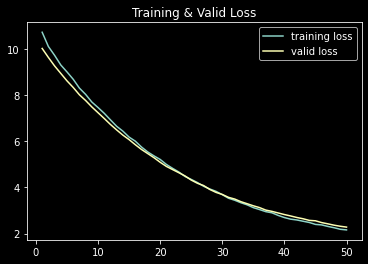

In [77]:
plot_loss(history)

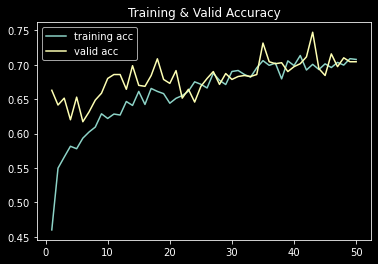

In [78]:
plot_acc(history)

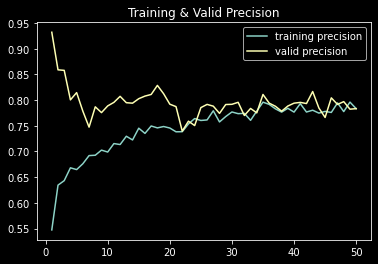

In [79]:
plot_precision(history)

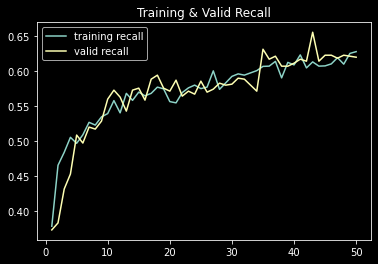

In [80]:
plot_recall(history)

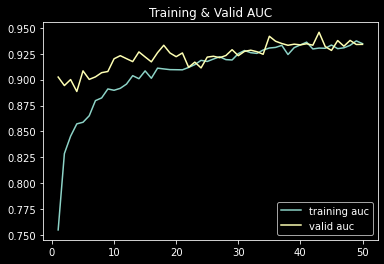

In [81]:
plot_auc(history)

### Evaluate model

In [82]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 648ms/step - loss: 1.9721 - categorical_accuracy: 0.7043 - precision: 0.7834 - recall: 0.6200 - auc: 0.9340


[1.9720697457140142, 0.70428574, 0.7833935, 0.62, 0.9339702]

In [83]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [84]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 512ms/step


In [85]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.96      0.97       359
         mild       0.37      0.59      0.46        68
     moderate       0.76      0.37      0.50       184
       severe       0.24      0.74      0.36        35
proliferative       0.36      0.28      0.31        54

     accuracy                           0.70       700
    macro avg       0.54      0.59      0.52       700
 weighted avg       0.77      0.70      0.71       700



In [86]:
confusion_matrix(y_true, y_pred)

array([[344,  11,   1,   2,   1],
       [  5,  40,   9,   7,   7],
       [  3,  41,  68,  57,  15],
       [  0,   2,   3,  26,   4],
       [  1,  13,   9,  16,  15]], dtype=int64)

## Fine Tune

In [87]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [88]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [89]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [90]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0940 - categorical_accuracy: 0.7148 - precision: 0.8071 - recall: 0.6352 - auc: 0.9397
Epoch 00001: val_loss improved from inf to 2.28554, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\best_fine_tune-20201213.h5
88/88 [==============================] - 146s 2s/step - loss: 2.0912 - categorical_accuracy: 0.7159 - precision: 0.8087 - recall: 0.6362 - auc: 0.9401 - val_loss: 2.2855 - val_categorical_accuracy: 0.7200 - val_precision: 0.7847 - val_recall: 0.6300 - val_auc: 0.9368
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1095 - categorical_accuracy: 0.7079 - precision: 0.8006 - recall: 0.6273 - auc: 0.9374
Epoch 00002: val_loss improved from 2.28554 to 2.28075, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\bes

Epoch 15/50
87/88 [============================>.] - ETA: 1s - loss: 2.0333 - categorical_accuracy: 0.7379 - precision: 0.8099 - recall: 0.6486 - auc: 0.9448
Epoch 00015: val_loss improved from 2.25687 to 2.25465, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold2\best_fine_tune-20201213.h5
88/88 [==============================] - 131s 1s/step - loss: 2.0325 - categorical_accuracy: 0.7387 - precision: 0.8097 - recall: 0.6494 - auc: 0.9450 - val_loss: 2.2547 - val_categorical_accuracy: 0.7171 - val_precision: 0.7764 - val_recall: 0.6400 - val_auc: 0.9404
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0337 - categorical_accuracy: 0.7263 - precision: 0.8078 - recall: 0.6475 - auc: 0.9441
Epoch 00016: val_loss did not improve from 2.25465
88/88 [==============================] - 128s 1s/step - loss: 2.0341 - categorical_accuracy: 0.7259 - precision: 0.8078 - recall: 0.6476 - auc: 0.9441 - val_loss: 2.2551 - val_categorical_

Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.9477 - categorical_accuracy: 0.7617 - precision: 0.8296 - recall: 0.6811 - auc: 0.9541
Epoch 00031: val_loss did not improve from 2.24637
88/88 [==============================] - 128s 1s/step - loss: 1.9455 - categorical_accuracy: 0.7634 - precision: 0.8312 - recall: 0.6826 - auc: 0.9544 - val_loss: 2.2465 - val_categorical_accuracy: 0.7371 - val_precision: 0.7888 - val_recall: 0.6614 - val_auc: 0.9450
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.9455 - categorical_accuracy: 0.7621 - precision: 0.8296 - recall: 0.6757 - auc: 0.9549
Epoch 00032: val_loss did not improve from 2.24637
88/88 [==============================] - 127s 1s/step - loss: 1.9472 - categorical_accuracy: 0.7616 - precision: 0.8281 - recall: 0.6751 - auc: 0.9546 - val_loss: 2.2506 - val_categorical_accuracy: 0.7343 - val_precision: 0.7898 - val_recall: 0.6657 - val_auc: 0.9448
Epoch 33/50
87/88 [===========================

Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.8824 - categorical_accuracy: 0.7679 - precision: 0.8276 - recall: 0.6996 - auc: 0.9572
Epoch 00048: val_loss did not improve from 2.24193
88/88 [==============================] - 128s 1s/step - loss: 1.8857 - categorical_accuracy: 0.7673 - precision: 0.8269 - recall: 0.6984 - auc: 0.9570 - val_loss: 2.2422 - val_categorical_accuracy: 0.7343 - val_precision: 0.7916 - val_recall: 0.6729 - val_auc: 0.9460
Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.9011 - categorical_accuracy: 0.7686 - precision: 0.8346 - recall: 0.7003 - auc: 0.9580
Epoch 00049: val_loss did not improve from 2.24193
88/88 [==============================] - 128s 1s/step - loss: 1.8983 - categorical_accuracy: 0.7680 - precision: 0.8350 - recall: 0.7001 - auc: 0.9580 - val_loss: 2.2458 - val_categorical_accuracy: 0.7314 - val_precision: 0.7910 - val_recall: 0.6757 - val_auc: 0.9461
Epoch 50/50
87/88 [===========================

In [91]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

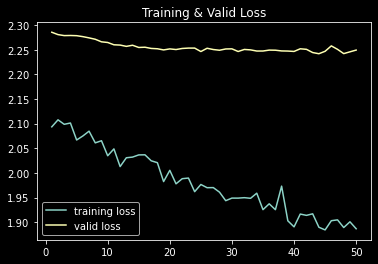

In [92]:
plot_loss(history)

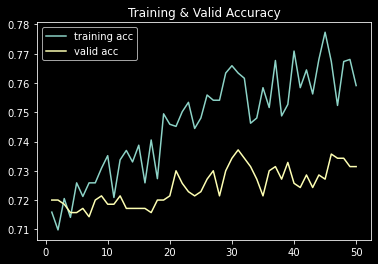

In [93]:
plot_acc(history)

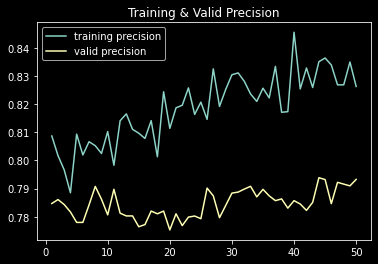

In [94]:
plot_precision(history)

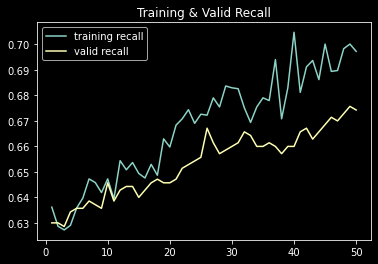

In [95]:
plot_recall(history)

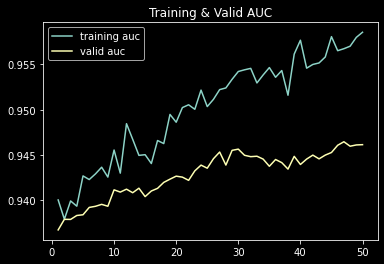

In [96]:
plot_auc(history)

### Evaluate model

In [97]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 576ms/step - loss: 1.8458 - categorical_accuracy: 0.7314 - precision: 0.7933 - recall: 0.6743 - auc: 0.9462


[1.8458411693572998, 0.73142856, 0.7932773, 0.6742857, 0.94615334]

In [98]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [99]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 511ms/step


In [100]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.98      0.96      0.97       359
         mild       0.41      0.63      0.50        68
     moderate       0.70      0.48      0.57       184
       severe       0.30      0.57      0.40        35
proliferative       0.29      0.26      0.27        54

     accuracy                           0.73       700
    macro avg       0.54      0.58      0.54       700
 weighted avg       0.76      0.73      0.74       700



In [101]:
confusion_matrix(y_true, y_pred)

array([[346,   9,   3,   0,   1],
       [  3,  43,  13,   5,   4],
       [  3,  37,  89,  31,  24],
       [  0,   3,   6,  20,   6],
       [  1,  12,  17,  10,  14]], dtype=int64)

# Fold 3

## Train classifier

In [102]:
del(model)

In [103]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [104]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.png,1
12,00f6c1be5a33.png,0
18,0151781fe50b.png,0


In [105]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))

In [106]:
conv_base, model = create_model()

In [107]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [108]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [109]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7799 - categorical_accuracy: 0.4613 - precision: 0.5357 - recall: 0.3662 - auc: 0.7502
Epoch 00001: val_loss improved from inf to 10.15134, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_classifier-20201213.h5
88/88 [==============================] - 142s 2s/step - loss: 10.7711 - categorical_accuracy: 0.4621 - precision: 0.5363 - recall: 0.3667 - auc: 0.7512 - val_loss: 10.1513 - val_categorical_accuracy: 0.6229 - val_precision: 0.8777 - val_recall: 0.4000 - val_auc: 0.8766
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1713 - categorical_accuracy: 0.5336 - precision: 0.6186 - recall: 0.4450 - auc: 0.8137
Epoch 00002: val_loss improved from 10.15134 to 9.71904, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fo

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9907 - categorical_accuracy: 0.6768 - precision: 0.7709 - recall: 0.5792 - auc: 0.9216
Epoch 00028: val_loss improved from 4.14292 to 4.02211, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_classifier-20201213.h5
88/88 [==============================] - 130s 1s/step - loss: 3.9895 - categorical_accuracy: 0.6773 - precision: 0.7714 - recall: 0.5801 - auc: 0.9215 - val_loss: 4.0221 - val_categorical_accuracy: 0.6671 - val_precision: 0.7996 - val_recall: 0.5529 - val_auc: 0.9240
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8508 - categorical_accuracy: 0.6793 - precision: 0.7671 - recall: 0.5918 - auc: 0.9201
Epoch 00029: val_loss improved from 4.02211 to 3.89603, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_classifier-20201213.h5
88/88 [==============================] - 130s 1s/step - loss

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.6612 - categorical_accuracy: 0.6905 - precision: 0.7780 - recall: 0.6070 - auc: 0.9271
Epoch 00042: val_loss improved from 2.86178 to 2.78488, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_classifier-20201213.h5
88/88 [==============================] - 131s 1s/step - loss: 2.6608 - categorical_accuracy: 0.6898 - precision: 0.7775 - recall: 0.6069 - auc: 0.9270 - val_loss: 2.7849 - val_categorical_accuracy: 0.7186 - val_precision: 0.7950 - val_recall: 0.5929 - val_auc: 0.9334
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.6094 - categorical_accuracy: 0.6880 - precision: 0.7716 - recall: 0.5998 - auc: 0.9288
Epoch 00043: val_loss improved from 2.78488 to 2.71228, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_classifier-20201213.h5
88/88 [==============================] - 131s 1s/step - loss

In [110]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

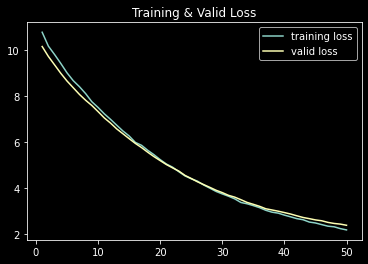

In [111]:
plot_loss(history)

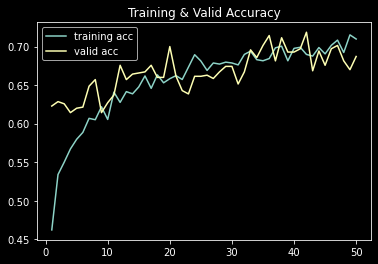

In [112]:
plot_acc(history)

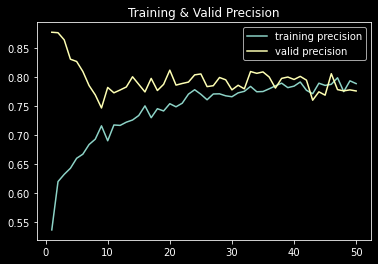

In [113]:
plot_precision(history)

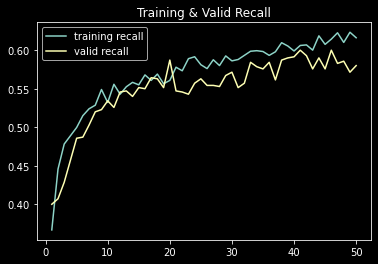

In [114]:
plot_recall(history)

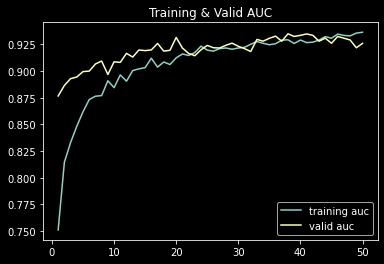

In [115]:
plot_auc(history)

### Evaluate model

In [116]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 574ms/step - loss: 2.0509 - categorical_accuracy: 0.6871 - precision: 0.7763 - recall: 0.5800 - auc: 0.9258


[2.0509308739141985, 0.68714285, 0.77629066, 0.58, 0.9257988]

In [117]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [118]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 514ms/step


In [119]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.93      0.94       359
         mild       0.37      0.57      0.45        68
     moderate       0.68      0.40      0.50       184
       severe       0.25      0.60      0.35        35
proliferative       0.26      0.26      0.26        54

     accuracy                           0.69       700
    macro avg       0.50      0.55      0.50       700
 weighted avg       0.74      0.69      0.70       700



In [120]:
confusion_matrix(y_true, y_pred)

array([[334,  21,   2,   1,   1],
       [  7,  39,  12,   3,   7],
       [  8,  34,  73,  43,  26],
       [  0,   1,   7,  21,   6],
       [  0,  11,  13,  16,  14]], dtype=int64)

## Fine Tune

In [121]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [122]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [123]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [124]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1708 - categorical_accuracy: 0.7086 - precision: 0.7797 - recall: 0.6179 - auc: 0.9355
Epoch 00001: val_loss improved from inf to 2.37211, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_fine_tune-20201213.h5
88/88 [==============================] - 147s 2s/step - loss: 2.1717 - categorical_accuracy: 0.7084 - precision: 0.7790 - recall: 0.6172 - auc: 0.9356 - val_loss: 2.3721 - val_categorical_accuracy: 0.6857 - val_precision: 0.7720 - val_recall: 0.5900 - val_auc: 0.9288
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1726 - categorical_accuracy: 0.7101 - precision: 0.7854 - recall: 0.6218 - auc: 0.9378
Epoch 00002: val_loss did not improve from 2.37211
88/88 [==============================] - 129s 1s/step - loss: 2.1710 - categorical_accuracy: 0.7094 - 

88/88 [==============================] - 132s 1s/step - loss: 2.0672 - categorical_accuracy: 0.7412 - precision: 0.8203 - recall: 0.6623 - auc: 0.9464 - val_loss: 2.3333 - val_categorical_accuracy: 0.6971 - val_precision: 0.7703 - val_recall: 0.6086 - val_auc: 0.9318
Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0709 - categorical_accuracy: 0.7296 - precision: 0.8086 - recall: 0.6475 - auc: 0.9458
Epoch 00016: val_loss did not improve from 2.33326
88/88 [==============================] - 129s 1s/step - loss: 2.0706 - categorical_accuracy: 0.7291 - precision: 0.8097 - recall: 0.6476 - auc: 0.9459 - val_loss: 2.3361 - val_categorical_accuracy: 0.7029 - val_precision: 0.7666 - val_recall: 0.6100 - val_auc: 0.9330
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 2.0749 - categorical_accuracy: 0.7332 - precision: 0.8087 - recall: 0.6479 - auc: 0.9467
Epoch 00017: val_loss did not improve from 2.33326
88/88 [==============================] - 129s 

Epoch 31/50
87/88 [============================>.] - ETA: 1s - loss: 1.9989 - categorical_accuracy: 0.7578 - precision: 0.8285 - recall: 0.6725 - auc: 0.9526
Epoch 00031: val_loss improved from 2.31061 to 2.30782, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_fine_tune-20201213.h5
88/88 [==============================] - 131s 1s/step - loss: 1.9950 - categorical_accuracy: 0.7573 - precision: 0.8294 - recall: 0.6708 - auc: 0.9525 - val_loss: 2.3078 - val_categorical_accuracy: 0.7100 - val_precision: 0.7821 - val_recall: 0.6257 - val_auc: 0.9339
Epoch 32/50
87/88 [============================>.] - ETA: 1s - loss: 1.9948 - categorical_accuracy: 0.7516 - precision: 0.8124 - recall: 0.6685 - auc: 0.9531
Epoch 00032: val_loss improved from 2.30782 to 2.30772, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold3\best_fine_tune-20201213.h5
88/88 [==============================] - 131s 1s/step - loss: 

Epoch 47/50
87/88 [============================>.] - ETA: 1s - loss: 1.9310 - categorical_accuracy: 0.7614 - precision: 0.8266 - recall: 0.6945 - auc: 0.9563
Epoch 00047: val_loss did not improve from 2.29990
88/88 [==============================] - 128s 1s/step - loss: 1.9290 - categorical_accuracy: 0.7620 - precision: 0.8269 - recall: 0.6948 - auc: 0.9564 - val_loss: 2.3012 - val_categorical_accuracy: 0.7143 - val_precision: 0.7791 - val_recall: 0.6500 - val_auc: 0.9377
Epoch 48/50
87/88 [============================>.] - ETA: 1s - loss: 1.9315 - categorical_accuracy: 0.7599 - precision: 0.8261 - recall: 0.6920 - auc: 0.9562
Epoch 00048: val_loss did not improve from 2.29990
88/88 [==============================] - 128s 1s/step - loss: 1.9293 - categorical_accuracy: 0.7605 - precision: 0.8261 - recall: 0.6926 - auc: 0.9562 - val_loss: 2.3028 - val_categorical_accuracy: 0.7129 - val_precision: 0.7828 - val_recall: 0.6486 - val_auc: 0.9375
Epoch 49/50
87/88 [===========================

In [125]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

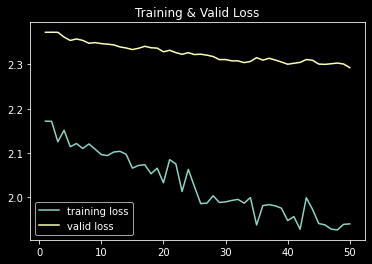

In [126]:
plot_loss(history)

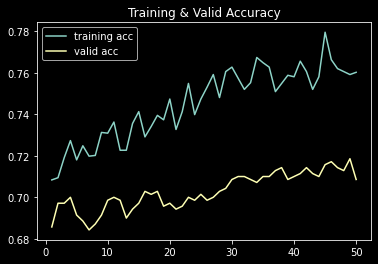

In [127]:
plot_acc(history)

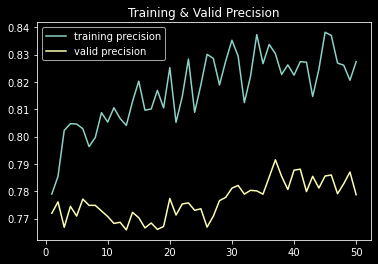

In [128]:
plot_precision(history)

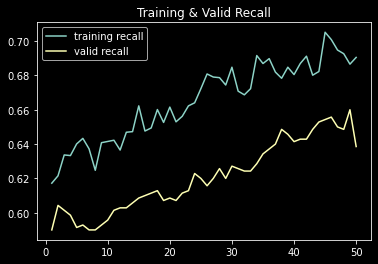

In [129]:
plot_recall(history)

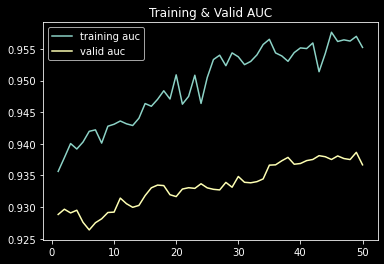

In [130]:
plot_auc(history)

### Evaluate model

In [131]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 578ms/step - loss: 1.9409 - categorical_accuracy: 0.7086 - precision: 0.7787 - recall: 0.6386 - auc: 0.9367


[1.9408926909620112, 0.70857143, 0.77874565, 0.63857144, 0.93667525]

In [132]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [133]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 516ms/step


In [134]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.95      0.95       359
         mild       0.41      0.56      0.47        68
     moderate       0.68      0.42      0.52       184
       severe       0.27      0.57      0.36        35
proliferative       0.31      0.35      0.33        54

     accuracy                           0.71       700
    macro avg       0.52      0.57      0.53       700
 weighted avg       0.75      0.71      0.72       700



In [135]:
confusion_matrix(y_true, y_pred)

array([[342,  12,   2,   1,   2],
       [  7,  38,  14,   2,   7],
       [  9,  34,  77,  39,  25],
       [  0,   1,   6,  20,   8],
       [  0,   8,  14,  13,  19]], dtype=int64)

# Fold 4

## Train classifier

In [136]:
del(model)

In [137]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [138]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.png,0
10,00cc2b75cddd.png,0
13,0104b032c141.png,3


In [139]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))

In [140]:
conv_base, model = create_model()

In [141]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [142]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [143]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7588 - categorical_accuracy: 0.4590 - precision: 0.5358 - recall: 0.3596 - auc: 0.7517
Epoch 00001: val_loss improved from inf to 10.10574, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\best_classifier-20201213.h5
88/88 [==============================] - 145s 2s/step - loss: 10.7497 - categorical_accuracy: 0.4594 - precision: 0.5370 - recall: 0.3605 - auc: 0.7528 - val_loss: 10.1057 - val_categorical_accuracy: 0.6037 - val_precision: 0.8799 - val_recall: 0.3562 - val_auc: 0.8637
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1161 - categorical_accuracy: 0.5396 - precision: 0.6242 - recall: 0.4532 - auc: 0.8208
Epoch 00002: val_loss improved from 10.10574 to 9.66385, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fo

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9470 - categorical_accuracy: 0.6838 - precision: 0.7693 - recall: 0.5905 - auc: 0.9223
Epoch 00028: val_loss improved from 4.08994 to 3.96965, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\best_classifier-20201213.h5
88/88 [==============================] - 131s 1s/step - loss: 3.9488 - categorical_accuracy: 0.6831 - precision: 0.7686 - recall: 0.5899 - auc: 0.9222 - val_loss: 3.9696 - val_categorical_accuracy: 0.6567 - val_precision: 0.7861 - val_recall: 0.5680 - val_auc: 0.9185
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.8304 - categorical_accuracy: 0.6715 - precision: 0.7578 - recall: 0.5801 - auc: 0.9202
Epoch 00029: val_loss improved from 3.96965 to 3.84957, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\best_classifier-20201213.h5
88/88 [==============================] - 133s 2s/step - loss

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.6288 - categorical_accuracy: 0.6924 - precision: 0.7735 - recall: 0.6035 - auc: 0.9276
Epoch 00042: val_loss improved from 2.79500 to 2.75003, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\best_classifier-20201213.h5
88/88 [==============================] - 129s 1s/step - loss: 2.6245 - categorical_accuracy: 0.6942 - precision: 0.7751 - recall: 0.6059 - auc: 0.9281 - val_loss: 2.7500 - val_categorical_accuracy: 0.6867 - val_precision: 0.7788 - val_recall: 0.5894 - val_auc: 0.9220
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.4906 - categorical_accuracy: 0.7120 - precision: 0.7926 - recall: 0.6216 - auc: 0.9358
Epoch 00043: val_loss improved from 2.75003 to 2.68130, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\best_classifier-20201213.h5
88/88 [==============================] - 131s 1s/step - loss

In [144]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

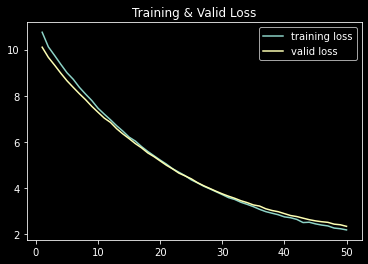

In [145]:
plot_loss(history)

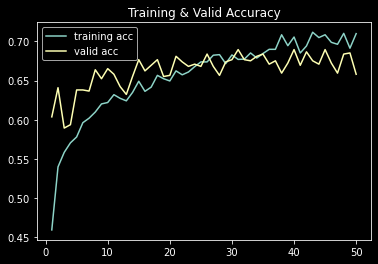

In [146]:
plot_acc(history)

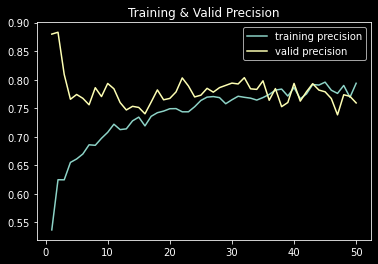

In [147]:
plot_precision(history)

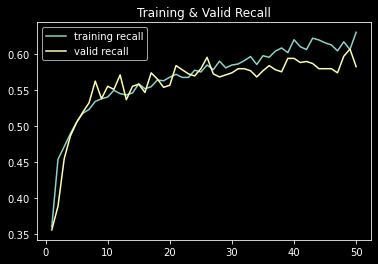

In [148]:
plot_recall(history)

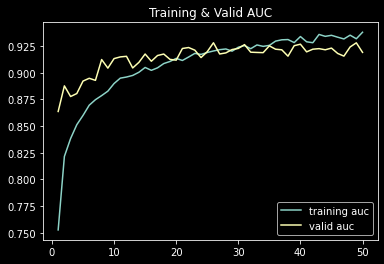

In [149]:
plot_auc(history)

### Evaluate model

In [150]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 16s 744ms/step - loss: 2.0628 - categorical_accuracy: 0.6581 - precision: 0.7593 - recall: 0.5823 - auc: 0.9190


[2.062823062593287, 0.65808296, 0.75932837, 0.5822604, 0.9190234]

In [151]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [152]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 511ms/step


In [153]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.98      0.89      0.93       359
         mild       0.31      0.56      0.40        68
     moderate       0.66      0.36      0.47       184
       severe       0.22      0.65      0.32        34
proliferative       0.30      0.26      0.28        54

     accuracy                           0.66       699
    macro avg       0.49      0.54      0.48       699
 weighted avg       0.74      0.66      0.68       699



In [154]:
confusion_matrix(y_true, y_pred)

array([[319,  32,   4,   2,   2],
       [  5,  38,  13,   5,   7],
       [  2,  42,  67,  53,  20],
       [  0,   3,   5,  22,   4],
       [  1,   7,  12,  20,  14]], dtype=int64)

## Fine Tune

In [155]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [156]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [157]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [158]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.1363 - categorical_accuracy: 0.7029 - precision: 0.7873 - recall: 0.6234 - auc: 0.9350
Epoch 00001: val_loss improved from inf to 2.32896, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\best_fine_tune-20201213.h5
88/88 [==============================] - 145s 2s/step - loss: 2.1373 - categorical_accuracy: 0.7038 - precision: 0.7889 - recall: 0.6249 - auc: 0.9353 - val_loss: 2.3290 - val_categorical_accuracy: 0.6667 - val_precision: 0.7634 - val_recall: 0.5908 - val_auc: 0.9217
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.1245 - categorical_accuracy: 0.7112 - precision: 0.7916 - recall: 0.6245 - auc: 0.9362
Epoch 00002: val_loss improved from 2.32896 to 2.32120, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\bes

87/88 [============================>.] - ETA: 1s - loss: 1.9833 - categorical_accuracy: 0.7416 - precision: 0.8149 - recall: 0.6682 - auc: 0.9507
Epoch 00029: val_loss did not improve from 2.26115
88/88 [==============================] - 132s 1s/step - loss: 1.9816 - categorical_accuracy: 0.7421 - precision: 0.8153 - recall: 0.6688 - auc: 0.9508 - val_loss: 2.2624 - val_categorical_accuracy: 0.6967 - val_precision: 0.7789 - val_recall: 0.6352 - val_auc: 0.9355
Epoch 30/50
87/88 [============================>.] - ETA: 1s - loss: 1.9949 - categorical_accuracy: 0.7362 - precision: 0.8110 - recall: 0.6621 - auc: 0.9501
Epoch 00030: val_loss did not improve from 2.26115
88/88 [==============================] - 131s 1s/step - loss: 1.9932 - categorical_accuracy: 0.7374 - precision: 0.8123 - recall: 0.6635 - auc: 0.9505 - val_loss: 2.2634 - val_categorical_accuracy: 0.7010 - val_precision: 0.7754 - val_recall: 0.6323 - val_auc: 0.9369
Epoch 31/50
87/88 [============================>.] - ETA: 

Epoch 45/50
87/88 [============================>.] - ETA: 1s - loss: 1.9324 - categorical_accuracy: 0.7629 - precision: 0.8242 - recall: 0.6881 - auc: 0.9556
Epoch 00045: val_loss did not improve from 2.24786
88/88 [==============================] - 131s 1s/step - loss: 1.9378 - categorical_accuracy: 0.7624 - precision: 0.8241 - recall: 0.6881 - auc: 0.9556 - val_loss: 2.2502 - val_categorical_accuracy: 0.7139 - val_precision: 0.7903 - val_recall: 0.6524 - val_auc: 0.9384
Epoch 46/50
87/88 [============================>.] - ETA: 1s - loss: 1.9272 - categorical_accuracy: 0.7597 - precision: 0.8329 - recall: 0.6953 - auc: 0.9559
Epoch 00046: val_loss improved from 2.24786 to 2.24652, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold4\best_fine_tune-20201213.h5
88/88 [==============================] - 134s 2s/step - loss: 1.9257 - categorical_accuracy: 0.7596 - precision: 0.8328 - recall: 0.6956 - auc: 0.9557 - val_loss: 2.2465 - val_categorical_

In [159]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

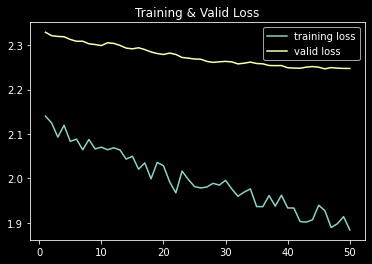

In [160]:
plot_loss(history)

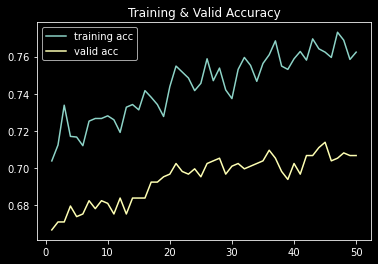

In [161]:
plot_acc(history)

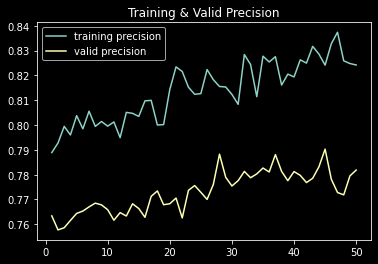

In [162]:
plot_precision(history)

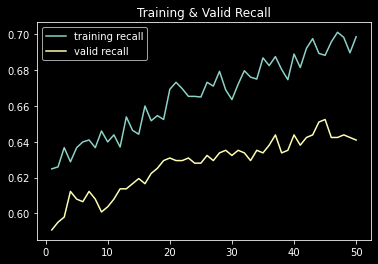

In [163]:
plot_recall(history)

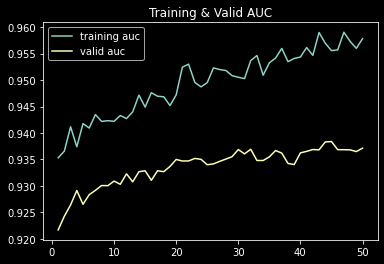

In [164]:
plot_auc(history)

### Evaluate model

In [165]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 581ms/step - loss: 1.9194 - categorical_accuracy: 0.7067 - precision: 0.7818 - recall: 0.6409 - auc: 0.9371


[1.9194300012155012, 0.70672387, 0.7818499, 0.6409156, 0.9371384]

In [166]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [167]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 522ms/step


In [168]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.97      0.94      0.96       359
         mild       0.40      0.62      0.49        68
     moderate       0.67      0.42      0.52       184
       severe       0.25      0.56      0.35        34
proliferative       0.33      0.33      0.33        54

     accuracy                           0.71       699
    macro avg       0.52      0.57      0.53       699
 weighted avg       0.75      0.71      0.72       699



In [169]:
confusion_matrix(y_true, y_pred)

array([[338,  16,   3,   2,   0],
       [  4,  42,  13,   3,   6],
       [  5,  39,  77,  37,  26],
       [  0,   3,   7,  19,   5],
       [  1,   5,  15,  15,  18]], dtype=int64)

# Fold 5

## Train classifier

In [170]:
del(model)

In [171]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [172]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.png,0
7,00a8624548a9.png,2
8,00b74780d31d.png,2


In [173]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_nakhon/fold'+str(fold))

In [174]:
conv_base, model = create_model()

In [175]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [176]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [177]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 10.7151 - categorical_accuracy: 0.4680 - precision: 0.5481 - recall: 0.3726 - auc: 0.7549
Epoch 00001: val_loss improved from inf to 10.11666, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold5\best_classifier-20201213.h5
88/88 [==============================] - 147s 2s/step - loss: 10.7148 - categorical_accuracy: 0.4691 - precision: 0.5487 - recall: 0.3726 - auc: 0.7556 - val_loss: 10.1167 - val_categorical_accuracy: 0.6323 - val_precision: 0.8974 - val_recall: 0.3505 - val_auc: 0.8833
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 10.1734 - categorical_accuracy: 0.5309 - precision: 0.6213 - recall: 0.4655 - auc: 0.8218
Epoch 00002: val_loss improved from 10.11666 to 9.66706, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fo

Epoch 28/50
87/88 [============================>.] - ETA: 1s - loss: 3.9112 - categorical_accuracy: 0.6874 - precision: 0.7742 - recall: 0.5974 - auc: 0.9251
Epoch 00028: val_loss improved from 4.10073 to 3.97227, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold5\best_classifier-20201213.h5
88/88 [==============================] - 135s 2s/step - loss: 3.9192 - categorical_accuracy: 0.6870 - precision: 0.7737 - recall: 0.5974 - auc: 0.9248 - val_loss: 3.9723 - val_categorical_accuracy: 0.6710 - val_precision: 0.7817 - val_recall: 0.5637 - val_auc: 0.9237
Epoch 29/50
87/88 [============================>.] - ETA: 1s - loss: 3.7897 - categorical_accuracy: 0.6881 - precision: 0.7589 - recall: 0.5916 - auc: 0.9248
Epoch 00029: val_loss improved from 3.97227 to 3.84943, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold5\best_classifier-20201213.h5
88/88 [==============================] - 135s 2s/step - loss

Epoch 42/50
87/88 [============================>.] - ETA: 1s - loss: 2.5817 - categorical_accuracy: 0.6852 - precision: 0.7674 - recall: 0.5985 - auc: 0.9285
Epoch 00042: val_loss improved from 2.84341 to 2.76002, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold5\best_classifier-20201213.h5
88/88 [==============================] - 134s 2s/step - loss: 2.5831 - categorical_accuracy: 0.6845 - precision: 0.7664 - recall: 0.5977 - auc: 0.9282 - val_loss: 2.7600 - val_categorical_accuracy: 0.6795 - val_precision: 0.8075 - val_recall: 0.5880 - val_auc: 0.9340
Epoch 43/50
87/88 [============================>.] - ETA: 1s - loss: 2.5067 - categorical_accuracy: 0.7134 - precision: 0.7940 - recall: 0.6227 - auc: 0.9369
Epoch 00043: val_loss improved from 2.76002 to 2.71768, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold5\best_classifier-20201213.h5
88/88 [==============================] - 133s 2s/step - loss

In [178]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

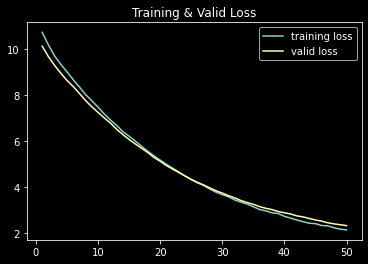

In [179]:
plot_loss(history)

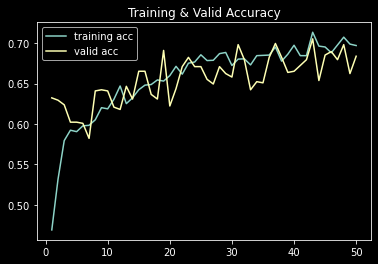

In [180]:
plot_acc(history)

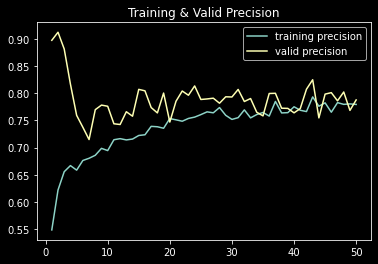

In [181]:
plot_precision(history)

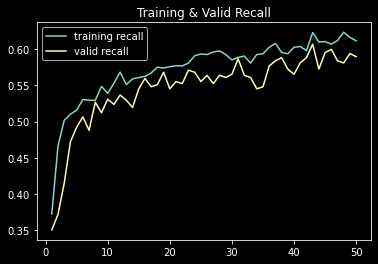

In [182]:
plot_recall(history)

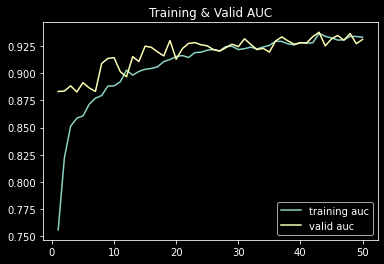

In [183]:
plot_auc(history)

### Evaluate model

In [184]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 17s 775ms/step - loss: 1.9812 - categorical_accuracy: 0.6838 - precision: 0.7878 - recall: 0.5894 - auc: 0.9313


[1.9812358942898838, 0.6838341, 0.7877629, 0.58941346, 0.93127215]

In [185]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [186]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 11s 513ms/step


In [187]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.94      0.96      0.95       360
         mild       0.46      0.54      0.49        67
     moderate       0.75      0.29      0.42       184
       severe       0.20      0.53      0.29        34
proliferative       0.28      0.44      0.34        54

     accuracy                           0.68       699
    macro avg       0.52      0.55      0.50       699
 weighted avg       0.75      0.68      0.69       699



In [188]:
confusion_matrix(y_true, y_pred)

array([[346,  10,   1,   0,   3],
       [ 11,  36,   9,   4,   7],
       [ 11,  24,  54,  52,  43],
       [  1,   1,   5,  18,   9],
       [  1,   8,   3,  18,  24]], dtype=int64)

## Fine Tune

In [189]:
# fine tune 2 blocks of Inception, block 9 & 10
# based on paper
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed8':
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [190]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_tune),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [191]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_body), monitor='val_loss', mode='min',save_best_only=True, verbose=1)]

In [192]:
history = model.fit(
    train_generator,
    epochs=epoch_tune,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/50
87/88 [============================>.] - ETA: 1s - loss: 2.0877 - categorical_accuracy: 0.7192 - precision: 0.7919 - recall: 0.6325 - auc: 0.9405
Epoch 00001: val_loss improved from inf to 2.34315, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold5\best_fine_tune-20201213.h5
88/88 [==============================] - 149s 2s/step - loss: 2.0854 - categorical_accuracy: 0.7192 - precision: 0.7921 - recall: 0.6331 - auc: 0.9406 - val_loss: 2.3432 - val_categorical_accuracy: 0.7024 - val_precision: 0.7850 - val_recall: 0.6009 - val_auc: 0.9339
Epoch 2/50
87/88 [============================>.] - ETA: 1s - loss: 2.0876 - categorical_accuracy: 0.7134 - precision: 0.7921 - recall: 0.6278 - auc: 0.9405
Epoch 00002: val_loss improved from 2.34315 to 2.34099, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_nakhon/fold5\bes

Epoch 16/50
87/88 [============================>.] - ETA: 1s - loss: 2.0046 - categorical_accuracy: 0.7358 - precision: 0.8065 - recall: 0.6567 - auc: 0.9473
Epoch 00016: val_loss did not improve from 2.31502
88/88 [==============================] - 132s 2s/step - loss: 2.0056 - categorical_accuracy: 0.7353 - precision: 0.8064 - recall: 0.6563 - auc: 0.9474 - val_loss: 2.3188 - val_categorical_accuracy: 0.7039 - val_precision: 0.7849 - val_recall: 0.6266 - val_auc: 0.9371
Epoch 17/50
87/88 [============================>.] - ETA: 1s - loss: 2.0132 - categorical_accuracy: 0.7322 - precision: 0.8034 - recall: 0.6588 - auc: 0.9461
Epoch 00017: val_loss did not improve from 2.31502
88/88 [==============================] - 133s 2s/step - loss: 2.0109 - categorical_accuracy: 0.7313 - precision: 0.8019 - recall: 0.6581 - auc: 0.9458 - val_loss: 2.3179 - val_categorical_accuracy: 0.7053 - val_precision: 0.7796 - val_recall: 0.6223 - val_auc: 0.9371
Epoch 18/50
87/88 [===========================

Epoch 49/50
87/88 [============================>.] - ETA: 1s - loss: 1.8447 - categorical_accuracy: 0.7712 - precision: 0.8294 - recall: 0.7011 - auc: 0.9611
Epoch 00049: val_loss did not improve from 2.30253
88/88 [==============================] - 132s 1s/step - loss: 1.8470 - categorical_accuracy: 0.7710 - precision: 0.8301 - recall: 0.7017 - auc: 0.9609 - val_loss: 2.3062 - val_categorical_accuracy: 0.7096 - val_precision: 0.7917 - val_recall: 0.6524 - val_auc: 0.9414
Epoch 50/50
87/88 [============================>.] - ETA: 1s - loss: 1.8785 - categorical_accuracy: 0.7683 - precision: 0.8352 - recall: 0.6997 - auc: 0.9587
Epoch 00050: val_loss did not improve from 2.30253
88/88 [==============================] - 132s 1s/step - loss: 1.8800 - categorical_accuracy: 0.7685 - precision: 0.8356 - recall: 0.6992 - auc: 0.9587 - val_loss: 2.3068 - val_categorical_accuracy: 0.7239 - val_precision: 0.7866 - val_recall: 0.6538 - val_auc: 0.9425


In [193]:
model.save(os.path.join(save_dir, save_EOE_train_body))

### Plot training result

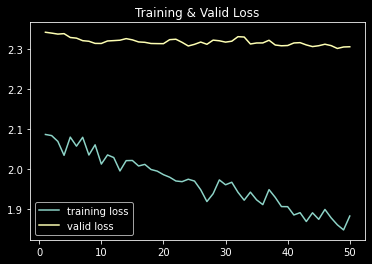

In [194]:
plot_loss(history)

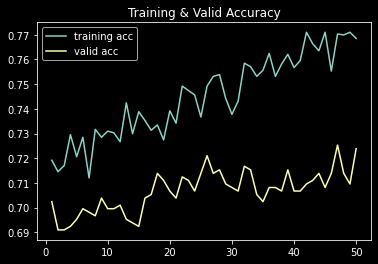

In [195]:
plot_acc(history)

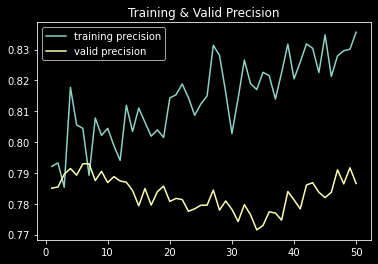

In [196]:
plot_precision(history)

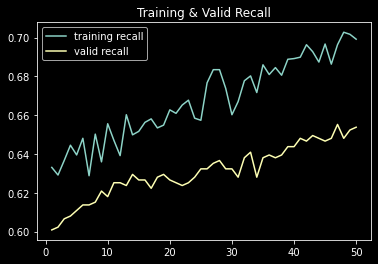

In [197]:
plot_recall(history)

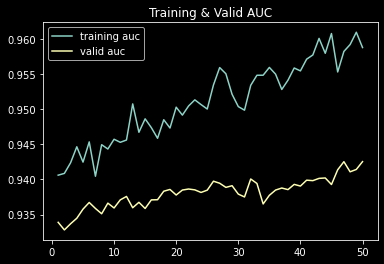

In [198]:
plot_auc(history)

### Evaluate model

In [199]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 13s 586ms/step - loss: 1.8696 - categorical_accuracy: 0.7239 - precision: 0.7866 - recall: 0.6538 - auc: 0.9425


[1.8695663593032144, 0.72389126, 0.7865749, 0.6537911, 0.94252473]

In [200]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [201]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 12s 528ms/step


In [202]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.96      0.96      0.96       360
         mild       0.44      0.70      0.54        67
     moderate       0.78      0.43      0.56       184
       severe       0.23      0.38      0.29        34
proliferative       0.30      0.41      0.35        54

     accuracy                           0.72       699
    macro avg       0.54      0.58      0.54       699
 weighted avg       0.78      0.72      0.73       699



In [203]:
confusion_matrix(y_true, y_pred)

array([[344,  13,   2,   0,   1],
       [  6,  47,   8,   2,   4],
       [  7,  36,  80,  26,  35],
       [  1,   2,   7,  13,  11],
       [  1,  10,   5,  16,  22]], dtype=int64)